In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import h5py
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import G2Net2022Dataset
from tqdm.notebook import tqdm

In [3]:
df = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/train_labels.csv')
test = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/sample_submission.csv')
df = df.loc[df['target'] != -1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 360, 512])


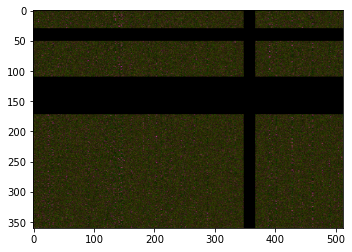

In [5]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from transforms import FrequencyMaskingTensor, TimeMaskingTensor

ds = G2Net2022Dataset(
    test, 
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'), 
    match_time=True,
    spec_diff=True,
    resize_factor=8, 
    transforms=A.Compose([
        # A.Resize(360, 1024), 
        ToTensorV2(), 
        FrequencyMaskingTensor(p=1.0), 
        TimeMaskingTensor(128, p=1.0),
        FrequencyMaskingTensor(p=1.0), ]),
    normalize='global')
for i in range(20):
    # plt.imshow(ds[i][0][0, :, :1000])
    data = ds[i][0]
    print(data.shape)
    plt.imshow(data.permute(1,2,0)[:, :1000])
    plt.show()
    break

# Get metadata

In [18]:
signal_summary = []
ds = G2Net2022Dataset(df, resize_factor=4, )
for idx in tqdm(range(len(df))):
    try:
        spec_h1, spec_l1 = ds[idx][0]
    except:
        print(f'ERROR: {idx}')
        continue
    signal_summary.append({
        'idx': idx,
        'h1_mean': spec_h1.mean().item(),
        'h1_max': spec_h1.max().item(),
        'h1_min': spec_h1.min().item(),
        'l1_mean': spec_l1.mean().item(),
        'l1_max': spec_l1.max().item(),
        'l1_min': spec_l1.min().item()
    })
signal_summary = pd.DataFrame(signal_summary)


  0%|          | 0/600 [00:00<?, ?it/s]

In [7]:
signal_summary.describe()

,idx,h1_mean,h1_max,h1_min,l1_mean,l1_max,l1_min
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,299.500000,2.251131,12.642118,0.044798,2.251228,12.628303,0.045448
std,173.349358,0.002746,1.496418,0.012991,0.002688,1.625919,0.013080
min,0.000000,2.245002,10.278623,0.004618,2.245160,10.458969,0.011588
25%,149.750000,2.249252,11.723351,0.035813,2.249438,11.589026,0.036310
50%,299.500000,2.250812,12.331841,0.045085,2.251028,12.246173,0.045540
75%,449.250000,2.252541,13.149575,0.053766,2.252677,13.112494,0.054471
max,599.000000,2.265751,26.310944,0.085897,2.262307,22.390112,0.083178


In [19]:
def count_gaps(timestamps, Tsft=1800):
    gap_length = timestamps[1:] - (timestamps[:-1] + Tsft)
    return (gap_length > 0).sum()

In [114]:
signal_summary = []
for gid in tqdm(test['id'].values):
    fname = Path('input/g2net-detecting-continuous-gravitational-waves/test')/f'{gid}.hdf5'
    with h5py.File(fname, 'r') as f:
        freq = list(f[gid]['frequency_Hz'])
        sig_h1, time_h1 = f[gid]['H1']['SFTs'], np.array(f[gid]['H1']['timestamps_GPS'])
        sig_l1, time_l1 = f[gid]['L1']['SFTs'], np.array(f[gid]['L1']['timestamps_GPS'])
        ts_start_h1, ts_end_h1 = time_h1[0], time_h1[-1]
        ts_start_l1, ts_end_l1 = time_l1[0], time_l1[-1]
        signal_summary.append({
            'idx': gid,
            'ts_start_h1': ts_start_h1,
            'ts_end_h1': ts_end_h1,
            'num_gaps_h1': count_gaps(time_h1),
            'length_h1': len(time_h1),
            'ts_start_l1': ts_start_l1,
            'ts_end_l1': ts_end_l1,
            'num_gaps_l1': count_gaps(time_l1),
            'length_l1': len(time_l1)
        })
signal_summary = pd.DataFrame(signal_summary)
signal_summary.describe()

  0%|          | 0/7975 [00:00<?, ?it/s]

,ts_start_h1,ts_end_h1,num_gaps_h1,length_h1,ts_start_l1,ts_end_l1,num_gaps_l1,length_l1
count,7.975000e+03,7.975000e+03,7975.000000,7975.000000,7.975000e+03,7.975000e+03,7975.000000,7975.000000
mean,1.238173e+09,1.248555e+09,307.224953,4586.144828,1.238173e+09,1.248554e+09,307.471223,4584.289655
std,7.032005e+03,2.345344e+04,14.579975,80.703136,6.977108e+03,2.317055e+04,14.595762,80.170951
min,1.238166e+09,1.248472e+09,247.000000,4281.000000,1.238166e+09,1.248477e+09,254.000000,4297.000000
25%,1.238168e+09,1.248539e+09,297.000000,4533.000000,1.238168e+09,1.248539e+09,297.000000,4531.000000
50%,1.238171e+09,1.248549e+09,307.000000,4587.000000,1.238171e+09,1.248549e+09,307.000000,4586.000000
75%,1.238176e+09,1.248565e+09,317.000000,4640.000000,1.238176e+09,1.248565e+09,317.000000,4638.000000
max,1.238240e+09,1.248724e+09,368.000000,4887.000000,1.238223e+09,1.248735e+09,369.000000,4878.000000


# Deal with gaps

In [7]:
from matplotlib import colors
from datetime import datetime


def add_gaps(timestamps, fourier_data, Tsft):
    gap_length = timestamps[1:] - (timestamps[:-1] + Tsft)
    gap_data = [fourier_data[:, 0]]
    gap_timestamps = [timestamps[0]]
    for ind, gap in enumerate(gap_length):
        if gap > 0:
            gap_data.append(np.full_like(fourier_data[:, ind], np.nan + 1j * np.nan))
            gap_timestamps.append(timestamps[ind] + Tsft)
        gap_data.append(fourier_data[:, ind + 1])
        gap_timestamps.append(timestamps[ind + 1])
    return np.hstack(gap_timestamps), np.vstack(gap_data).T


def plot_real_imag_spectrograms_with_gaps(timestamps, frequency, fourier_data, Tsft):
    gap_timestamps, gap_data = add_gaps(timestamps, fourier_data, Tsft)
    return plot_real_imag_spectrograms(
        gap_timestamps, frequency, gap_data
    )


def plot_real_imag_spectrograms(timestamps, frequency, fourier_data):
    fig, axs = plt.subplots(1, 2, figsize=(16, 10))

    for ax in axs:
        ax.set(xlabel="SFT index", ylabel="Frequency [Hz]")

    time_in_days = (timestamps - timestamps[0]) / 1800

    axs[0].set_title("SFT Real part")
    c = axs[0].pcolormesh(
        time_in_days,
        frequency,
        fourier_data.real,
        norm=colors.CenteredNorm(),
    )
    fig.colorbar(c, ax=axs[0], orientation="horizontal", label="Fourier Amplitude")

    axs[1].set_title("SFT Imaginary part")
    c = axs[1].pcolormesh(
        time_in_days,
        frequency,
        fourier_data.imag,
        norm=colors.CenteredNorm(),
    )

    fig.colorbar(c, ax=axs[1], orientation="horizontal", label="Fourier Amplitude")

    return fig, axs

(360, 4612) (360, 4653)
[   407    407    407    407    407    407    407    407    407    407
    407    407    407    407    407  -8248  -8248  -8248  -8248  -8248
  -6656  -4604  -4604  -4604  -4604  -4604  -4604  -4604  -4604  -4604
  -4604  -4604  -4604  -4604  -9841  -9841 -12552 -12552 -12552 -12552
 -12552 -12552 -12552 -12552 -12552 -12552 -12552 -10768 -10768 -26108]
[ 407  407  407  407  407  407  407  407  407  407  407  407  407  407
  407 2207 4007 5807 7607 9407  752 1004 1004  796  796  796  796  796
  796  796  796  796  796  796  796  796  796 2596 4396 6196  959  959
 2759   48   48   48   48   48   48   48]


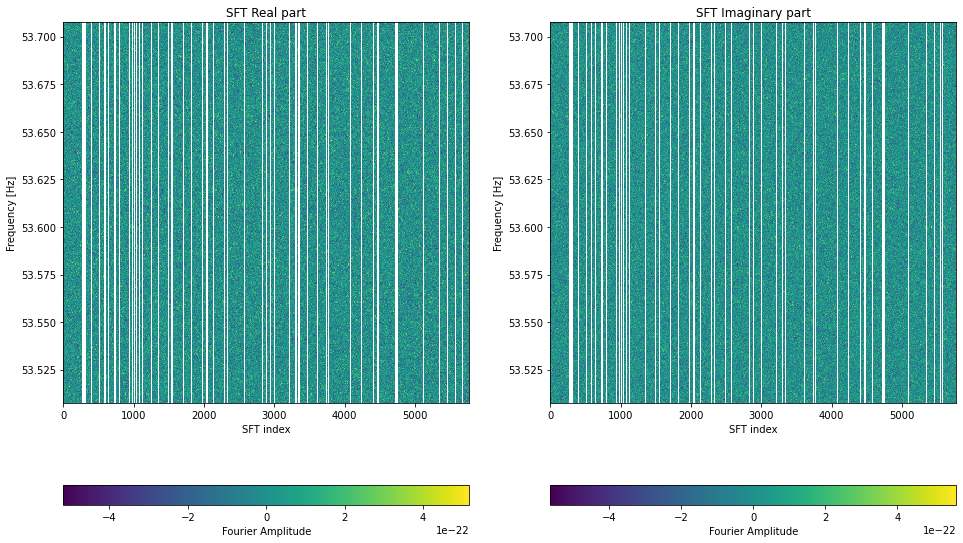

In [8]:
gid = df.iloc[0].id
fname = Path('input/g2net-detecting-continuous-gravitational-waves/train')/f'{gid}.pickle'
with open(fname, 'rb') as fp:
    f = pickle.load(fp)
    freq = list(f[gid]['frequency_Hz'])
    sig_h1, time_h1 = f[gid]['H1']['SFTs'], np.array(f[gid]['H1']['timestamps_GPS'])
    sig_l1, time_l1 = f[gid]['L1']['SFTs'], np.array(f[gid]['L1']['timestamps_GPS'])
    print(sig_h1.shape, sig_l1.shape)
    print(time_h1[:50] - time_l1[:50])
    plot_real_imag_spectrograms_with_gaps(time_h1, freq, sig_h1, 1800)
    # time_h1_true, sig_h1_true = add_gaps(time_h1, sig_h1, 1800)
    # time_l1_true, sig_l1_true = add_gaps(time_l1, sig_l1, 1800)
    match_idx = np.searchsorted(time_l1, time_h1) - 1
    # print(match_idx)
    print(time_h1[:50] - time_l1[match_idx][:50])
    

In [13]:
(time_h1[-1] - time_h1[0]) / 1800

5769.898888888889

In [14]:
# print(
#     datetime.utcfromtimestamp(time_h1_true[0]).strftime('%Y-%m-%d %H:%M:%S'),
#     datetime.utcfromtimestamp(time_h1_true[1]).strftime('%Y-%m-%d %H:%M:%S'),
#     datetime.utcfromtimestamp(time_h1_true[-1]).strftime('%Y-%m-%d %H:%M:%S')
# ), print(
#     datetime.utcfromtimestamp(time_l1_true[0]).strftime('%Y-%m-%d %H:%M:%S'),
#     datetime.utcfromtimestamp(time_l1_true[1]).strftime('%Y-%m-%d %H:%M:%S'),
#     datetime.utcfromtimestamp(time_l1_true[-1]).strftime('%Y-%m-%d %H:%M:%S')
# )

# Wave generation

In [10]:
np.stack([np.ones((100, 200)), np.ones((100, 200))]).shape

(2, 100, 200)

In [203]:
# import pyfstat
# from pyfstat.utils import get_sft_as_arrays
# import math
# import random

In [204]:
# ts_with_gaps = []
# for i, gid in enumerate(tqdm(test['id'].values)):
#     fname = Path('input/g2net-detecting-continuous-gravitational-waves/test')/f'{gid}.hdf5'
#     with h5py.File(fname, 'r') as f:
#         freq = list(f[gid]['frequency_Hz'])
#         sig_h1, time_h1 = f[gid]['H1']['SFTs'], np.array(f[gid]['H1']['timestamps_GPS'])
#         sig_l1, time_l1 = f[gid]['L1']['SFTs'], np.array(f[gid]['L1']['timestamps_GPS'])
#         ts_with_gaps.append({'H1': time_h1, 'L1': time_l1})

In [205]:
# def make_signal(idx, test_timestamps):
#     # signal_depth = np.random.uniform(5, 100)
#     signal_depth = 1
#     signal_center = np.random.uniform(50, 500)
#     timestamps_set = random.choice(test_timestamps)
#     timestamps_h1, timestamps_l1 = timestamps_set['H1'], timestamps_set['L1']
#     noise_kwargs_h1 = {
#         "outdir": 'pyfstat',
#         "label": f'signal{idx}_h1',
#         "timestamps": timestamps_h1,
#         # "duration": 4 * 30 * 86400,
#         # "Tsft": 1800,
#         "detectors": "H1",
#         "sqrtSX": 1e-23,
#         "SFTWindowType": "tukey",
#         "SFTWindowBeta": 0.01,
#         "Band": 0.4,
#     }
#     noise_kwargs_l1 = noise_kwargs_h1.copy()
#     noise_kwargs_l1['label'] = f'signal{idx}_l1'
#     noise_kwargs_l1['detectors'] = 'L1'
#     noise_kwargs_l1['timestamps'] = timestamps_l1
   
#     signal_kwargs_h1 = {
#         "F0": signal_center,
#         "F1": -1 * 10**np.random.uniform(-12, -8),
#         # "F1": np.random.uniform(-1e-9, 0),
#         "F2": 0,
#         "Alpha": np.random.uniform(0, math.pi * 2),
#         "Delta": np.random.uniform(-math.pi/2, math.pi/2),
#         "h0": noise_kwargs_h1['sqrtSX'] / signal_depth,
#         "cosi": np.random.uniform(-1, 1),
#         "psi": np.random.uniform(-math.pi/4, math.pi/4),
#         "phi": np.random.uniform(0, math.pi*2),
#         "tref": timestamps_h1[0],
#     }
#     signal_kwargs_l1 = signal_kwargs_h1.copy()
#     signal_kwargs_l1['h0'] = noise_kwargs_l1['sqrtSX'] / signal_depth
#     signal_kwargs_l1['tref'] = timestamps_l1[0]

#     writer_h1 = pyfstat.Writer(**noise_kwargs_h1, **signal_kwargs_h1)
#     writer_h1.make_data()
#     writer_l1 = pyfstat.Writer(**noise_kwargs_l1, **signal_kwargs_l1)
#     writer_l1.make_data()
#     freqs_h1, times_h1, sft_data_h1 = get_sft_as_arrays(writer_h1.sftfilepath)
#     freqs_l1, times_l1, sft_data_l1 = get_sft_as_arrays(writer_l1.sftfilepath)
#     freqs = freqs_h1
#     times = {'H1': times_h1['H1'], 'L1': times_l1['L1']}
#     sft_data = {'H1': sft_data_h1['H1'], 'L1': sft_data_l1['L1']}
#     slice_start = np.random.randint(90, 270)
#     sft_crop = {}
#     for d in ['H1', 'L1']:
#         sft_crop[d] = sft_data[d][slice_start:slice_start+360]
#     freqs = freqs[slice_start:slice_start+360]
#     for fname in [
#         f'{noise_kwargs_h1["label"]}.cff',
#         f'{noise_kwargs_l1["label"]}.cff',
#         f'H-{len(timestamps_h1)}_H1_1800SFT_{noise_kwargs_h1["label"]}-{timestamps_h1[0]}-{timestamps_h1[-1]-timestamps_h1[0]+1800}.sft',
#         f'L-{len(timestamps_l1)}_L1_1800SFT_{noise_kwargs_l1["label"]}-{timestamps_l1[0]}-{timestamps_l1[-1]-timestamps_l1[0]+1800}.sft',
#         f'{noise_kwargs_h1["label"]}_timestamps_H1.csv',
#         f'{noise_kwargs_l1["label"]}_timestamps_L1.csv']:
#         (Path(f'{noise_kwargs_h1["outdir"]}')/fname).unlink()
#     instance_id = f'pos_{idx}'
#     return {instance_id: {
#             'H1': {
#                 'SFTs': sft_crop['H1'], 
#                 'timestamps_GPS': times['H1']
#             },
#             'L1': {
#                 'SFTs': sft_crop['L1'], 
#                 'timestamps_GPS': times['L1']
#             },
#             'frequency_Hz': freqs}}, {
#             'H1': dict(noise_kwargs_h1, **signal_kwargs_h1),
#             'L1': dict(noise_kwargs_l1, **signal_kwargs_l1),
#         }


# def make_noise(idx, test_timestamps):
#     signal_center = np.random.uniform(50, 500)
#     timestamps_set = random.choice(test_timestamps)
#     timestamps_h1, timestamps_l1 = timestamps_set['H1'], timestamps_set['L1']
#     noise_kwargs_h1 = {
#         "outdir": 'pyfstat',
#         "label": f'signal{idx}_h1',
#         "timestamps": timestamps_h1,
#         # "duration": 4 * 30 * 86400,
#         # "Tsft": 1800,
#         "detectors": "H1",
#         "sqrtSX": 1e-23,
#         "SFTWindowType": "tukey",
#         "SFTWindowBeta": 0.01,
#         "F0": signal_center,
#         "Band": 0.4,
#     }
#     noise_kwargs_l1 = noise_kwargs_h1.copy()
#     noise_kwargs_l1['label'] = f'signal{idx}_l1'
#     noise_kwargs_l1['detectors'] = 'L1'
#     noise_kwargs_l1['timestamps'] = timestamps_l1


#     writer_h1 = pyfstat.Writer(**noise_kwargs_h1)
#     writer_h1.make_data()
#     writer_l1 = pyfstat.Writer(**noise_kwargs_l1)
#     writer_l1.make_data()
#     freqs_h1, times_h1, sft_data_h1 = get_sft_as_arrays(writer_h1.sftfilepath)
#     freqs_l1, times_l1, sft_data_l1 = get_sft_as_arrays(writer_l1.sftfilepath)
#     freqs = freqs_h1
#     times = {'H1': times_h1['H1'], 'L1': times_l1['L1']}
#     sft_data = {'H1': sft_data_h1['H1'], 'L1': sft_data_l1['L1']}
#     slice_start = np.random.randint(90, 270)
#     sft_crop = {}
#     for d in ['H1', 'L1']:
#         sft_crop[d] = sft_data[d][slice_start:slice_start+360]
#     freqs = freqs[slice_start:slice_start+360]
#     for fname in [
#         f'H-{len(timestamps_h1)}_H1_1800SFT_{noise_kwargs_h1["label"]}-{timestamps_h1[0]}-{timestamps_h1[-1]-timestamps_h1[0]+1800}.sft',
#         f'L-{len(timestamps_l1)}_L1_1800SFT_{noise_kwargs_l1["label"]}-{timestamps_l1[0]}-{timestamps_l1[-1]-timestamps_l1[0]+1800}.sft',
#         f'{noise_kwargs_h1["label"]}_timestamps_H1.csv',
#         f'{noise_kwargs_l1["label"]}_timestamps_L1.csv']:
#         (Path(f'{noise_kwargs_h1["outdir"]}')/fname).unlink()
#     instance_id = f'neg_{idx}'
#     return {instance_id: {
#             'H1': {
#                 'SFTs': sft_crop['H1'], 
#                 'timestamps_GPS': times['H1']
#             },
#             'L1': {
#                 'SFTs': sft_crop['L1'], 
#                 'timestamps_GPS': times['L1']
#             },
#             'frequency_Hz': freqs}}, {
#             'H1': noise_kwargs_h1,
#             'L1': noise_kwargs_l1,
#         }


In [206]:
# res, meta = make_signal(0, ts_with_gaps)
# res = res['pos_0']
# plot_real_imag_spectrograms_with_gaps(
#     res["L1"]['timestamps_GPS'], res['frequency_Hz'], res["L1"]['SFTs'], 1800
# )

In [207]:
# res, meta = make_noise(0, ts_with_gaps)
# res = res['neg_0']
# plot_real_imag_spectrograms_with_gaps(
#     res["L1"]['timestamps_GPS'], res['frequency_Hz'], res["L1"]['SFTs'], 1800
# )

In [208]:
# def save_dict_to_hdf5(dic, filename):
#     """
#     ....
#     """
#     with h5py.File(filename, 'w') as h5file:
#         recursively_save_dict_contents_to_group(h5file, '/', dic)


# def recursively_save_dict_contents_to_group(h5file, path, dic):
#     """
#     ....
#     """
#     for key, item in dic.items():
#         if isinstance(item, (np.ndarray, np.int64, np.float64, str, bytes)):
#             h5file[path + key] = item
#         elif isinstance(item, dict):
#             recursively_save_dict_contents_to_group(h5file, path + key + '/', item)
#         else:
#             raise ValueError('Cannot save %s type'%type(item))

In [209]:
# res, meta = make_noise(0, ts_with_gaps)
# save_dict_to_hdf5(res, 'test.hdf5')

In [210]:
# with h5py.File('test.hdf5', 'r') as f:
#     print(f['neg_0']['H1'].keys())
#     print(np.array(f['neg_0']['H1']['SFTs']))

In [6]:
v0_df = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v0.csv')

<AxesSubplot:xlabel='H1_h0', ylabel='Count'>

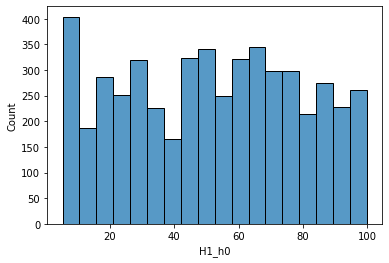

In [12]:
sns.histplot(1e-23/v0_df['H1_h0'])

In [13]:
ds = G2Net2022Dataset(
    v0_df, 
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/v0'),
    match_time=True,
    # spec_diff=True,
    transforms=A.Compose([
        A.Resize(360, 1024), ToTensorV2()]),
    normalize='global')

In [15]:
(1e-23/v0_df['H1_h0']).head()

0    12.827824
1    97.162911
2    73.498674
3    91.776646
4    43.946574
Name: H1_h0, dtype: float64

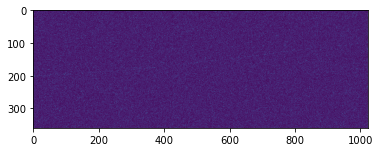

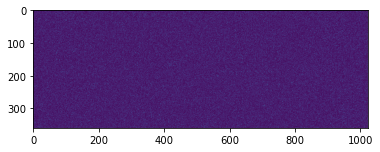

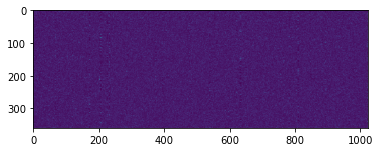

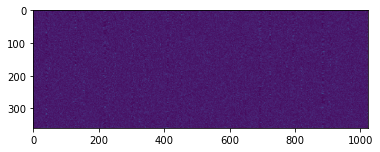

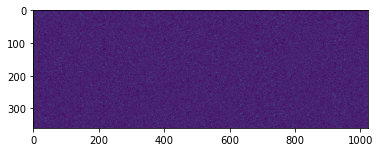

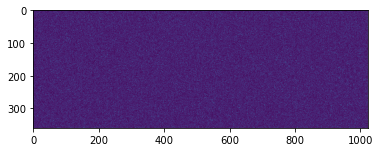

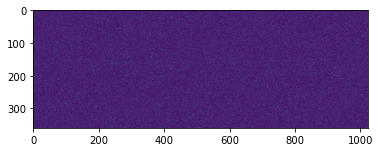

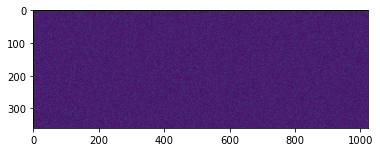

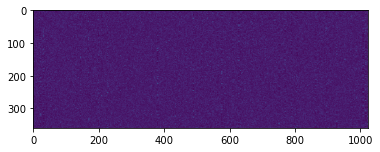

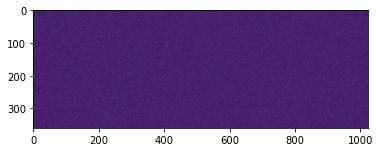

In [14]:
for i in range(10):
    # plt.imshow(ds[i][0].permute(1,2,0))
    plt.imshow(ds[i][0][0])
    plt.show()
    # break